# Wrangle data

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import chi2
from math import sqrt
import os
from env import host, user, password, get_db_url
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
import wrangle
import explore
import warnings
warnings.filterwarnings("ignore")

alpha = 0.5

## Acquire

In [ ]:
def get_zillow_data():
    """Seeks to read the cached zillow.csv first """
    filename = "zillow.csv"

    if os.path.isfile(filename):
        return pd.read_csv(filename)
    else:
        return get_new_zillow_data()



def get_new_zillow_data():
    '''this function gathers selected data from the ZILLOW SQL DF
    and uses the get_db_url function to connect to said dataframe'''
    sql = '''
    SELECT 
        bedroomcnt AS bedrooms, 
        bathroomcnt AS bathrooms,
        calculatedfinishedsquarefeet AS sq_ft,
        taxvaluedollarcnt AS tax_value,
        yearbuilt AS year_built,
        taxamount AS tax_amnt,
        lotsizesquarefeet AS lot_size,
        fips
    FROM
        properties_2017
       JOIN propertylandusetype using (propertylandusetypeid)
       JOIN predictions_2017 USING(parcelid)
    WHERE propertylandusedesc in ("Single Family Residential", 
                                  "Inferred Single Family Residential")
       AND transactiondate LIKE "2017%%";          
    '''
    return pd.read_sql(sql, get_db_url('zillow'))

In [ ]:
df = wrangle.get_zillow_data()
df.head()

In [2]:
df = wrangle.get_zillow_data()
df.head()

,bedrooms,bathrooms,sq_ft,tax_value,year_built,lot_size,LA,orange,ventura
0,4,3.5,3100,1023282,1998,4506,0,1,0
1,2,1.0,1465,464000,1967,12647,0,0,1
2,3,2.0,1243,564778,1962,8432,0,1,0
3,4,3.0,2376,145143,1970,13038,1,0,0
4,4,3.0,2962,773303,1950,63000,1,0,0


## Prepare

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df.isnull().sum()

In [ ]:
df.isnull().sum().sum() #/ len(df)

we will drop nulls as they are a about 1% of the total data and should not have an impacting effect on exploration or modeling

In [ ]:
df = df.dropna()

In [ ]:
df.duplicated().sum()
#minimal amount of duplicates so we will drop those too

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.shape

In [ ]:
51835 / 52441

In [ ]:
1-0.9884441562899258

We still have over 98% of our data after drops

In [ ]:
df.fips.unique()

In [ ]:
list(df.columns)

In [ ]:
def mahalanobis(x=None, data=None, cov=None):

    x_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left, x_mu.T)
    return mahal.diagonal()



In [ ]:
#create new column in dataframe that contains Mahalanobis distance for each row
df['mahalanobis'] = mahalanobis(x=df, data=df[['bedrooms',
 'bathrooms',
 'sq_ft',
 'tax_value',
 'year_built',
 'tax_amnt',
 'lot_size',
 'fips']])



In [ ]:
#display first five rows of dataframe
df.head()

In [ ]:
#calculate p-value for each mahalanobis distance 
df['p'] = 1 - chi2.cdf(df['mahalanobis'], 3)

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
df[df.p > 0.001].shape

In [ ]:
df.shape

In [ ]:
def remove_outliers(df):
    #create new column in dataframe that contains Mahalanobis distance for each row
    df['mahalanobis'] = mahalanobis(x=df, data=df[['bedrooms',
 'bathrooms',
 'sq_ft',
 'tax_value',
 'year_built',
 'tax_amnt',
 'lot_size',
 'fips']])
    
    #calculate p-value for each mahalanobis distance 
    df['p'] = 1 - chi2.cdf(df['mahalanobis'], 3)
    
    # drop rowss with p-value of less than 0.001
    df = df[df.p > 0.001]
    
    # drop calculative columns
    df = df.drop(['mahalanobis', 'p'], axis = 1)
    
    return df

In [ ]:
df = remove_outliers(df)
df.shape

In [ ]:
df.head()

In [ ]:
df.drop(['mahalanobis', 'p'], axis = 1)

In [ ]:
df = wrangle.wrangle_zillow()


In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
# changing fips codes to strings
df['fips'] = df.fips.apply(lambda fips: '0' + str(int(fips)))

In [ ]:
df.info()

## Split

In [3]:
def train_test_validate_split(df, test_size=.2, validate_size=.3, random_state=99):
    '''
    This function takes in a dataframe, then splits that dataframe into three separate samples
    called train, test, and validate, for use in machine learning modeling.
    Three dataframes are returned in the following order: train, test, validate. 
    
    The function also prints the size of each sample.
    '''
    train, test = train_test_split(df, test_size=.2, random_state=99)
    train, validate = train_test_split(train, test_size=.3, random_state=99)
    
    print(f'train\t n = {train.shape[0]}')
    print(f'test\t n = {test.shape[0]}')
    print(f'validate n = {validate.shape[0]}')
    
    return train, test, validate

In [4]:
train, test, validate = train_test_validate_split(df, test_size=.2, validate_size=.3, random_state=99)

train	 n = 27767
test	 n = 9918
validate n = 11901


# explore

In [ ]:
explore.plot_variable_pairs(train)

In [ ]:
explore.plot_categorical_and_continuous_vars(train)

In [ ]:
def correlation_test(data_for_category_1, data_for_category_2, alpha=.05):
    '''
    This function takes in data for two variables and performs a pearsons r statistitical test for correlation. 
    It outputs to the console values for r and p and compares them to a given alpha value, then outputs to the 
    console whether or not to reject the null hypothesis based on that comparison. 
    '''
    # display hypotheses
    print(f'H0: There is no linear correlation between {data_for_category_1.name} and {data_for_category_2.name}.')
    print(f'H1: There is a linear correlation between {data_for_category_1.name} and {data_for_category_2.name}.')
    # conduct the stats test and store values for p and r
    r, p = stats.pearsonr(data_for_category_1, data_for_category_2)
    # display the p and r values
    print('\nr = ', round(r, 2))
    print('p = ', round(p, 3))
    # compare p to alpha, display whether to reject the null hypothesis
    if p < alpha:
        print('\nReject H0')
    else:
        print('\nFail to Reject H0')

In [ ]:
correlation_test(train.year_built, train.tax_value, alpha=.05)

In [ ]:
correlation_test(train.lot_size, train.tax_value, alpha=.05)

In [51]:
def value_correlations(train):
    '''
    This functino takes in the zillow train sample and uses pandas and seaborn to create a
    ordered list and heatmap of the correlations between the various quantitative feeatures and the target. 
    '''
    # create a dataframe of correlation values, sorted in descending order
    corr = pd.DataFrame(train.corr().abs().tax_value).sort_values(by='tax_value', ascending=False)
    # rename the correlation column
    corr.columns = ['correlation (abs)']
    # establish figure size
    plt.figure(figsize=(10,10))
    # creat the heatmap using the correlation dataframe created above
    sns.heatmap(corr, annot=True, cmap="mako")
    # establish a plot title
    plt.title('Features\' Correlation with Value')
    # display the plot
    plt.show()

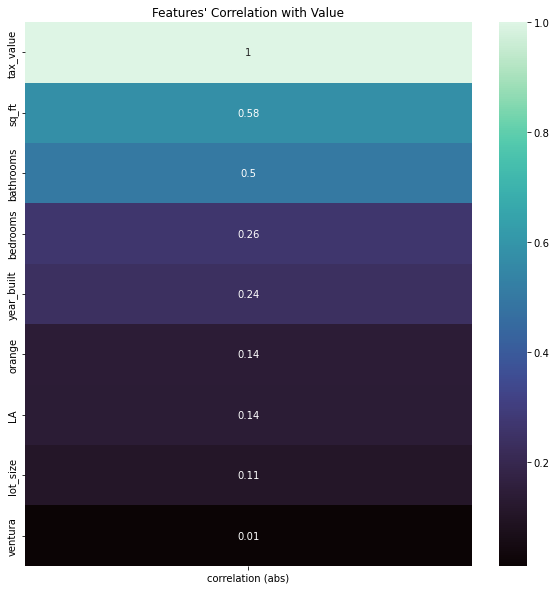

In [52]:
value_correlations(train_scaled)

In [ ]:
train.sort_values(by= 'tax_value', ascending=False)

In [ ]:
train.mean()

## Scale

In [5]:
train.tax_value.mean(), train.tax_value.median()

(452278.90330248134, 359832.0)

In [6]:
target = 'tax_value'

In [53]:
def MM_scale_zillow(train, validate, test):
    '''
    This takes in the train, validate, and test dataframes, as well as the target label. 
    It then fits a scaler object to the train sample based on the given sample_type, applies that
    scaler to the train, validate, and test samples, and appends the new scaled data to the 
    dataframes as additional columns with the prefix 'scaled_'. 
    train, validate, and test dataframes are returned, in that order. 
    '''
    target = 'taxvalue'
    
    # identify quantitative features to scale
    quant_features = [col for col in train.columns if (train[col].dtype != 'object') & (col != target)]
    
    # establish empty dataframes for storing scaled dataset
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    
    # create and fit the scaler
    scaler = MinMaxScaler().fit(train[quant_features])
    
    # adding scaled features to scaled dataframes
    train_scaled[quant_features] = scaler.transform(train[quant_features])
    validate_scaled[quant_features] = scaler.transform(validate[quant_features])
    test_scaled[quant_features] = scaler.transform(test[quant_features])
   

    return train_scaled, validate_scaled, test_scaled

In [55]:
train_scaled, validate_scaled, test_scaled = MM_scale_zillow(train, validate, test)

In [9]:
train_scaled.head()

,bedrooms,bathrooms,sq_ft,tax_value,year_built,lot_size,LA,orange,ventura
47983,0.500000,0.333333,0.172335,46340,0.549618,0.024584,1.0,0.0,0.0
41197,0.500000,0.333333,0.268370,482242,0.496183,0.018301,1.0,0.0,0.0
6789,0.333333,0.166667,0.097269,109035,0.274809,0.014754,1.0,0.0,0.0
35424,0.666667,0.416667,0.304317,618000,0.870229,0.007476,0.0,1.0,0.0
44266,0.666667,0.333333,0.282819,661000,0.519084,0.016652,1.0,0.0,0.0


In [10]:
def determine_regression_baseline(train, target):
    '''
    This function takes in a train sample and a continuous target variable label and 
    determines whether the mean or median performs better as a baseline prediction. 
    '''
    # create empty dataframe for storing prediction results
    results = pd.DataFrame(index=train.index)
    # assign actual values for the target variable
    results['actual'] = train[target]
    # assign a baseline using mean
    results['baseline_mean'] = train[target].mean()
    # assign a baseline using median
    results['baseline_median']= train[target].median()
    
    # get RMSE values for each potential baseline
    RMSE_baseline_mean = sqrt(sklearn.metrics.mean_squared_error(results.actual, results.baseline_mean))
    RMSE_baseline_median = sqrt(sklearn.metrics.mean_squared_error(results.actual, results.baseline_median))
    
    # compare the two RMSE values; drop the lowest performer and assign the highest performer to baseline variable
    if RMSE_baseline_median < RMSE_baseline_mean:
        results = results.drop(columns='baseline_mean')
        results['RMSE_baseline'] = RMSE_baseline_median
        baseline = 'median'
    else:
        results = results.drop(columns='baseline_median')
        results['RMSE_baseline'] = RMSE_baseline_mean
        baseline = 'mean'
    # print the results
    print(f'The highest performing baseline is the {baseline} target value.')

In [41]:
determine_regression_baseline(train_scaled,target)

The highest performing baseline is the mean target value.


## create x and y sets

In [19]:
train_scaled.head()

,bedrooms,bathrooms,sq_ft,tax_value,year_built,lot_size,LA,orange,ventura
47983,0.500000,0.333333,0.172335,46340,0.549618,0.024584,1.0,0.0,0.0
41197,0.500000,0.333333,0.268370,482242,0.496183,0.018301,1.0,0.0,0.0
6789,0.333333,0.166667,0.097269,109035,0.274809,0.014754,1.0,0.0,0.0
35424,0.666667,0.416667,0.304317,618000,0.870229,0.007476,0.0,1.0,0.0
44266,0.666667,0.333333,0.282819,661000,0.519084,0.016652,1.0,0.0,0.0


In [20]:
X_train = train_scaled.drop(columns=['tax_value'])
y_train = train_scaled.drop(columns = X_train)

X_validate = validate_scaled.drop(columns=['tax_value'])
y_validate = validate_scaled.drop(columns = X_validate)

X_test = test_scaled.drop(columns=['tax_value'])
y_test = test_scaled.drop(columns = X_test)

In [21]:
X_train.head()

,bedrooms,bathrooms,sq_ft,year_built,lot_size,LA,orange,ventura
47983,0.500000,0.333333,0.172335,0.549618,0.024584,1.0,0.0,0.0
41197,0.500000,0.333333,0.268370,0.496183,0.018301,1.0,0.0,0.0
6789,0.333333,0.166667,0.097269,0.274809,0.014754,1.0,0.0,0.0
35424,0.666667,0.416667,0.304317,0.870229,0.007476,0.0,1.0,0.0
44266,0.666667,0.333333,0.282819,0.519084,0.016652,1.0,0.0,0.0


In [22]:
y_train.head()

,tax_value
47983,46340
41197,482242
6789,109035
35424,618000
44266,661000


## Baseline and Root Mean Square Error

In [23]:
#Adding mean baseline value to y_train:
y_train['baseline_mean'] = train_scaled['tax_value'].mean()
#Adding mean baseline value to y_validate:
y_validate['baseline_mean'] = train_scaled['tax_value'].mean()

In [24]:
y_train.head()

,tax_value,baseline_mean
47983,46340,452278.903302
41197,482242,452278.903302
6789,109035,452278.903302
35424,618000,452278.903302
44266,661000,452278.903302


In [25]:
# Creating an empty list for baseline results:
results = []

# Creating a dictionary of baseline mean values:
baseline_mean = {
    'model':'baseline_mean',
    'RMSE_train': mean_squared_error(y_train['tax_value'], y_train['baseline_mean']) ** 0.5,
    'RMSE_validate': mean_squared_error(y_validate['tax_value'], y_validate['baseline_mean'])** 0.5
}
#Appending baseline mean to results list:
results.append(baseline_mean)

#Creating a DataFrame from the list of result dictionaries:
results = pd.DataFrame(results)
results

,model,RMSE_train,RMSE_validate
0,baseline_mean,389831.755763,395757.225741


## OLS Model

In [34]:
# Create model
lm = LinearRegression(normalize=True,)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train)

# predict train
y_train['lm_tax_value_pred'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.lm_tax_value_pred)**(1/2)

# predict validate
y_validate['lm_tax_value_pred'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.lm_tax_value_pred)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

evs = explained_variance_score(y_train.tax_value, y_train.lm_tax_value_pred)
print('Train Explained Variance = ', round(evs,3))
evs = explained_variance_score(y_validate.tax_value, y_validate.lm_tax_value_pred)
print('Validate Explained Variance = ', round(evs,3))

RMSE for OLS using LinearRegression
Training/In-Sample:  310510.72730761056 
Validation/Out-of-Sample:  314145.1168870388
Train Explained Variance =  0.366
Validate Explained Variance =  0.37


## Lasso Lars model

In [40]:
# Create model
lars = LassoLars(alpha=5)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.tax_value)

# predict train
y_train['lm_tax_value_pred'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.lm_tax_value_pred)**(1/2)

# predict validate
y_validate['lm_tax_value_pred'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.lm_tax_value_pred)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

evs = explained_variance_score(y_train.tax_value, y_train.lm_tax_value_pred)
print('Train Explained Variance = ', round(evs,3))
evs = explained_variance_score(y_validate.tax_value, y_validate.lm_tax_value_pred)
print('Validate Explained Variance = ', round(evs,3))

RMSE for OLS using LinearRegression
Training/In-Sample:  310510.72730761056 
Validation/Out-of-Sample:  314145.1168870388
Train Explained Variance =  0.366
Validate Explained Variance =  0.37


AttributeError: 'LassoLars' object has no attribute 'coef_'